Showing Stan samples correctly for the simple "bunch of normals being led around" problem.

In [1]:
# set up Python
import json
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2
from cmdstanpy import CmdStanModel
import plotnine
from plotnine import *

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
N = 1000

In [3]:
data_file_name = "stan_test_data.json"
src_file_name = "stan_test_src.stan"

In [4]:
stan_src = """
data {
  int<lower=1> N;
}
parameters {
  real c;
  vector[N] x;
}
model {
  c ~ normal(0, 1);
  x ~ normal(c, 1);
}
"""

In [5]:

data_str = f"""
{{
  "N": {N}
}}
"""

In [6]:

with open(data_file_name, "w", encoding="utf8") as file:
    file.write(data_str)
with open(src_file_name, "w", encoding="utf8") as file:
    file.write(stan_src)
# instantiate the model object
model = CmdStanModel(stan_file=src_file_name)
# fit the model and draw observations
# https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample
# https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.optimize
fit = model.sample(
    data=data_file_name,
    show_progress=False,
    show_console=False,
)
# get the samples
res = fit.draws_pd()

In [7]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,c,x[1],x[2],...,x[991],x[992],x[993],x[994],x[995],x[996],x[997],x[998],x[999],x[1000]
0,-502.181,0.989124,0.039381,6.0,63.0,0.0,1039.890,1.202800,2.140020,1.951540,...,-0.250740,0.708426,2.182510,-0.297629,1.565300,1.970750,2.573730,1.136550,0.450416,0.207581
1,-577.541,0.858656,0.039381,6.0,63.0,0.0,1082.280,1.198540,1.824950,0.771153,...,1.106260,0.729391,1.635550,-0.044056,0.231159,0.950913,0.187111,1.012260,0.302869,-0.770531
2,-573.371,0.982291,0.039381,6.0,63.0,0.0,1057.210,1.211270,0.711869,1.777490,...,1.194370,1.542580,0.815376,2.595510,2.450510,1.527260,2.523130,1.477320,2.197060,3.277020
3,-493.827,0.774206,0.039381,6.0,63.0,0.0,1065.090,1.327650,-1.092190,1.151480,...,1.553500,1.541900,2.073580,0.920499,0.570808,-0.830750,0.563212,1.695310,0.700802,1.788740
4,-536.309,0.985206,0.039381,6.0,63.0,0.0,1027.240,1.169310,-0.412258,1.543720,...,1.429870,0.371451,1.161200,0.404757,0.550248,-0.426682,0.601854,0.316046,1.349200,1.965960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-487.019,0.995538,0.069291,6.0,63.0,0.0,982.514,0.050630,1.396280,0.756732,...,-0.780566,-0.633323,-1.152260,0.395358,0.239538,1.314710,-2.100010,0.430273,-1.399280,0.465986
3996,-493.411,0.688424,0.069291,6.0,63.0,0.0,1020.730,0.036261,-1.287860,-0.664248,...,0.830494,0.703676,1.500510,-0.353151,0.031015,-1.390110,2.056210,-0.251549,1.818650,-0.517719
3997,-478.509,0.999056,0.069291,6.0,63.0,0.0,975.823,-0.020560,1.830380,1.010160,...,0.104484,-0.002208,-1.124260,0.842289,-0.949420,-0.329994,-0.216680,1.107180,-0.366594,-1.027690
3998,-479.681,0.989820,0.069291,6.0,63.0,0.0,952.403,0.020102,-1.874870,-1.428540,...,-0.234872,0.033524,1.004990,-0.848289,1.311250,0.294719,0.222490,-0.987126,-0.156774,0.909007


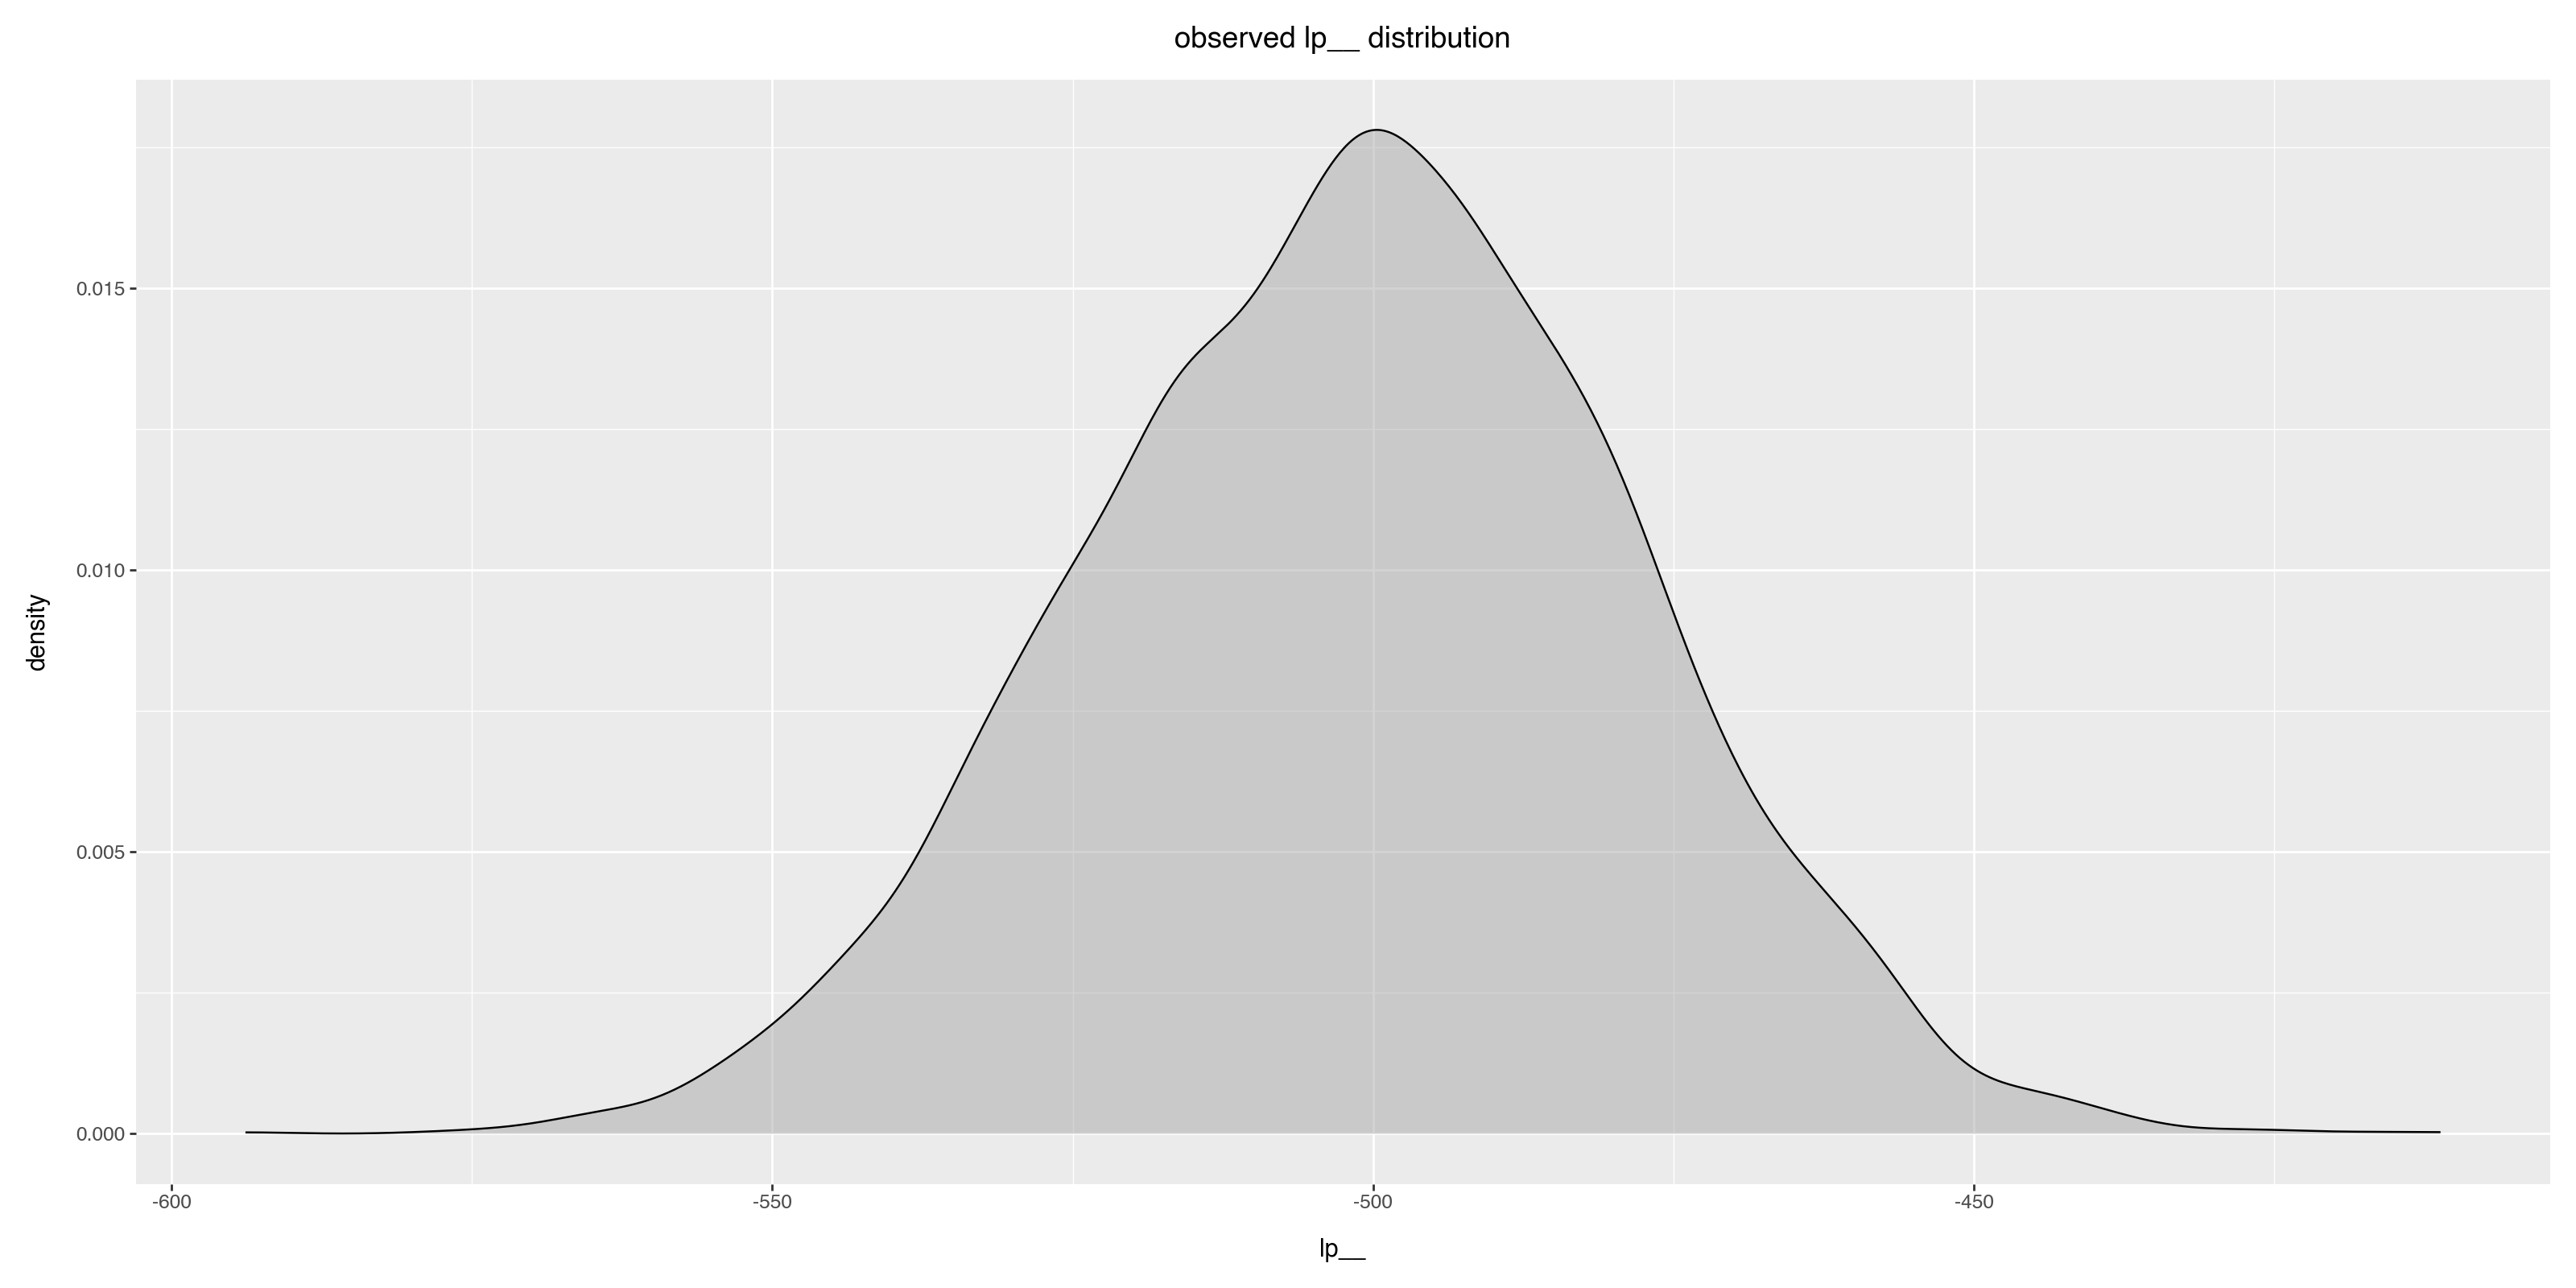

In [8]:
(
    ggplot(
        data=res,
        mapping=aes(x='lp__')
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle("observed lp__ distribution")
)

In [9]:
c = res['c']
log_density = -(c**2)/2 - np.log(2 * np.pi)/2
sum_sq = np.zeros(res.shape[0], dtype=float)
for i in range(1, N+1):
    x = res[f'x[{i}]']
    log_density += -((x - c)**2)/2 - np.log(2 * np.pi)/2 
    sum_sq += (x - c)**2
res['log_density'] = log_density
res['sum_sq'] = sum_sq

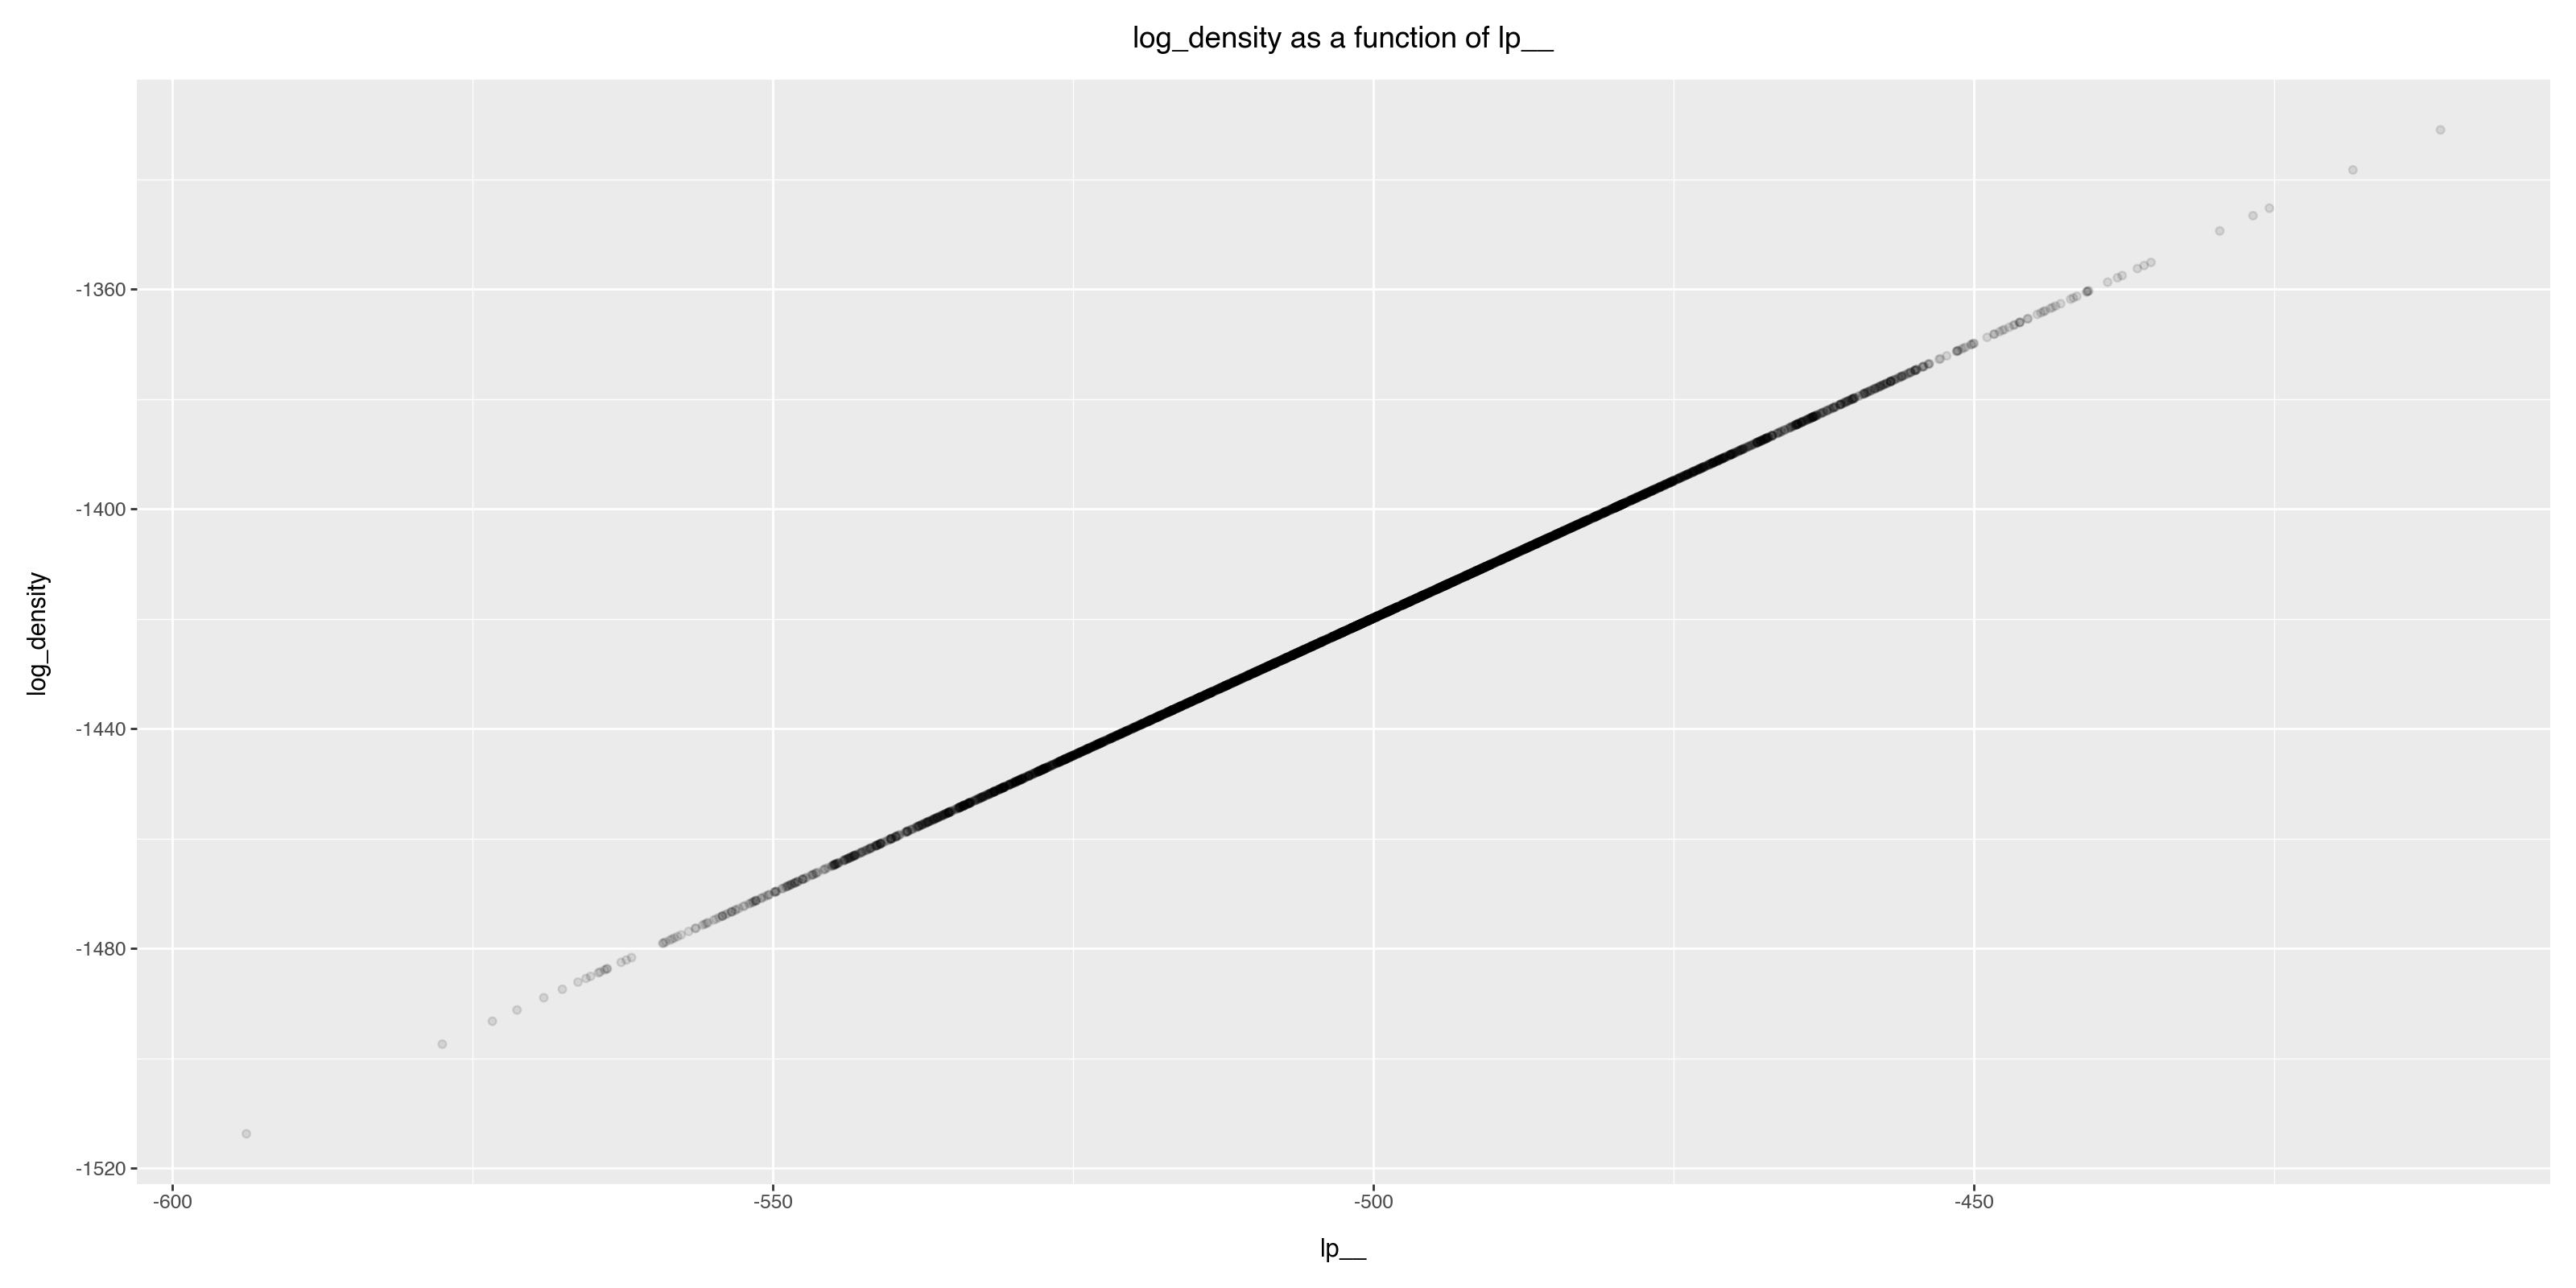

In [10]:
(
    ggplot(
        data=res,
        mapping=aes(x='lp__', y='log_density')
    )
    + geom_point(alpha=0.1)
    + ggtitle("log_density as a function of lp__")
)

In [11]:
log_density_model = LinearRegression()
log_density_model.fit(res[['lp__']], res['log_density'])
(log_density_model.coef_, log_density_model.intercept_)

(array([0.9999997]), -919.8576272661624)

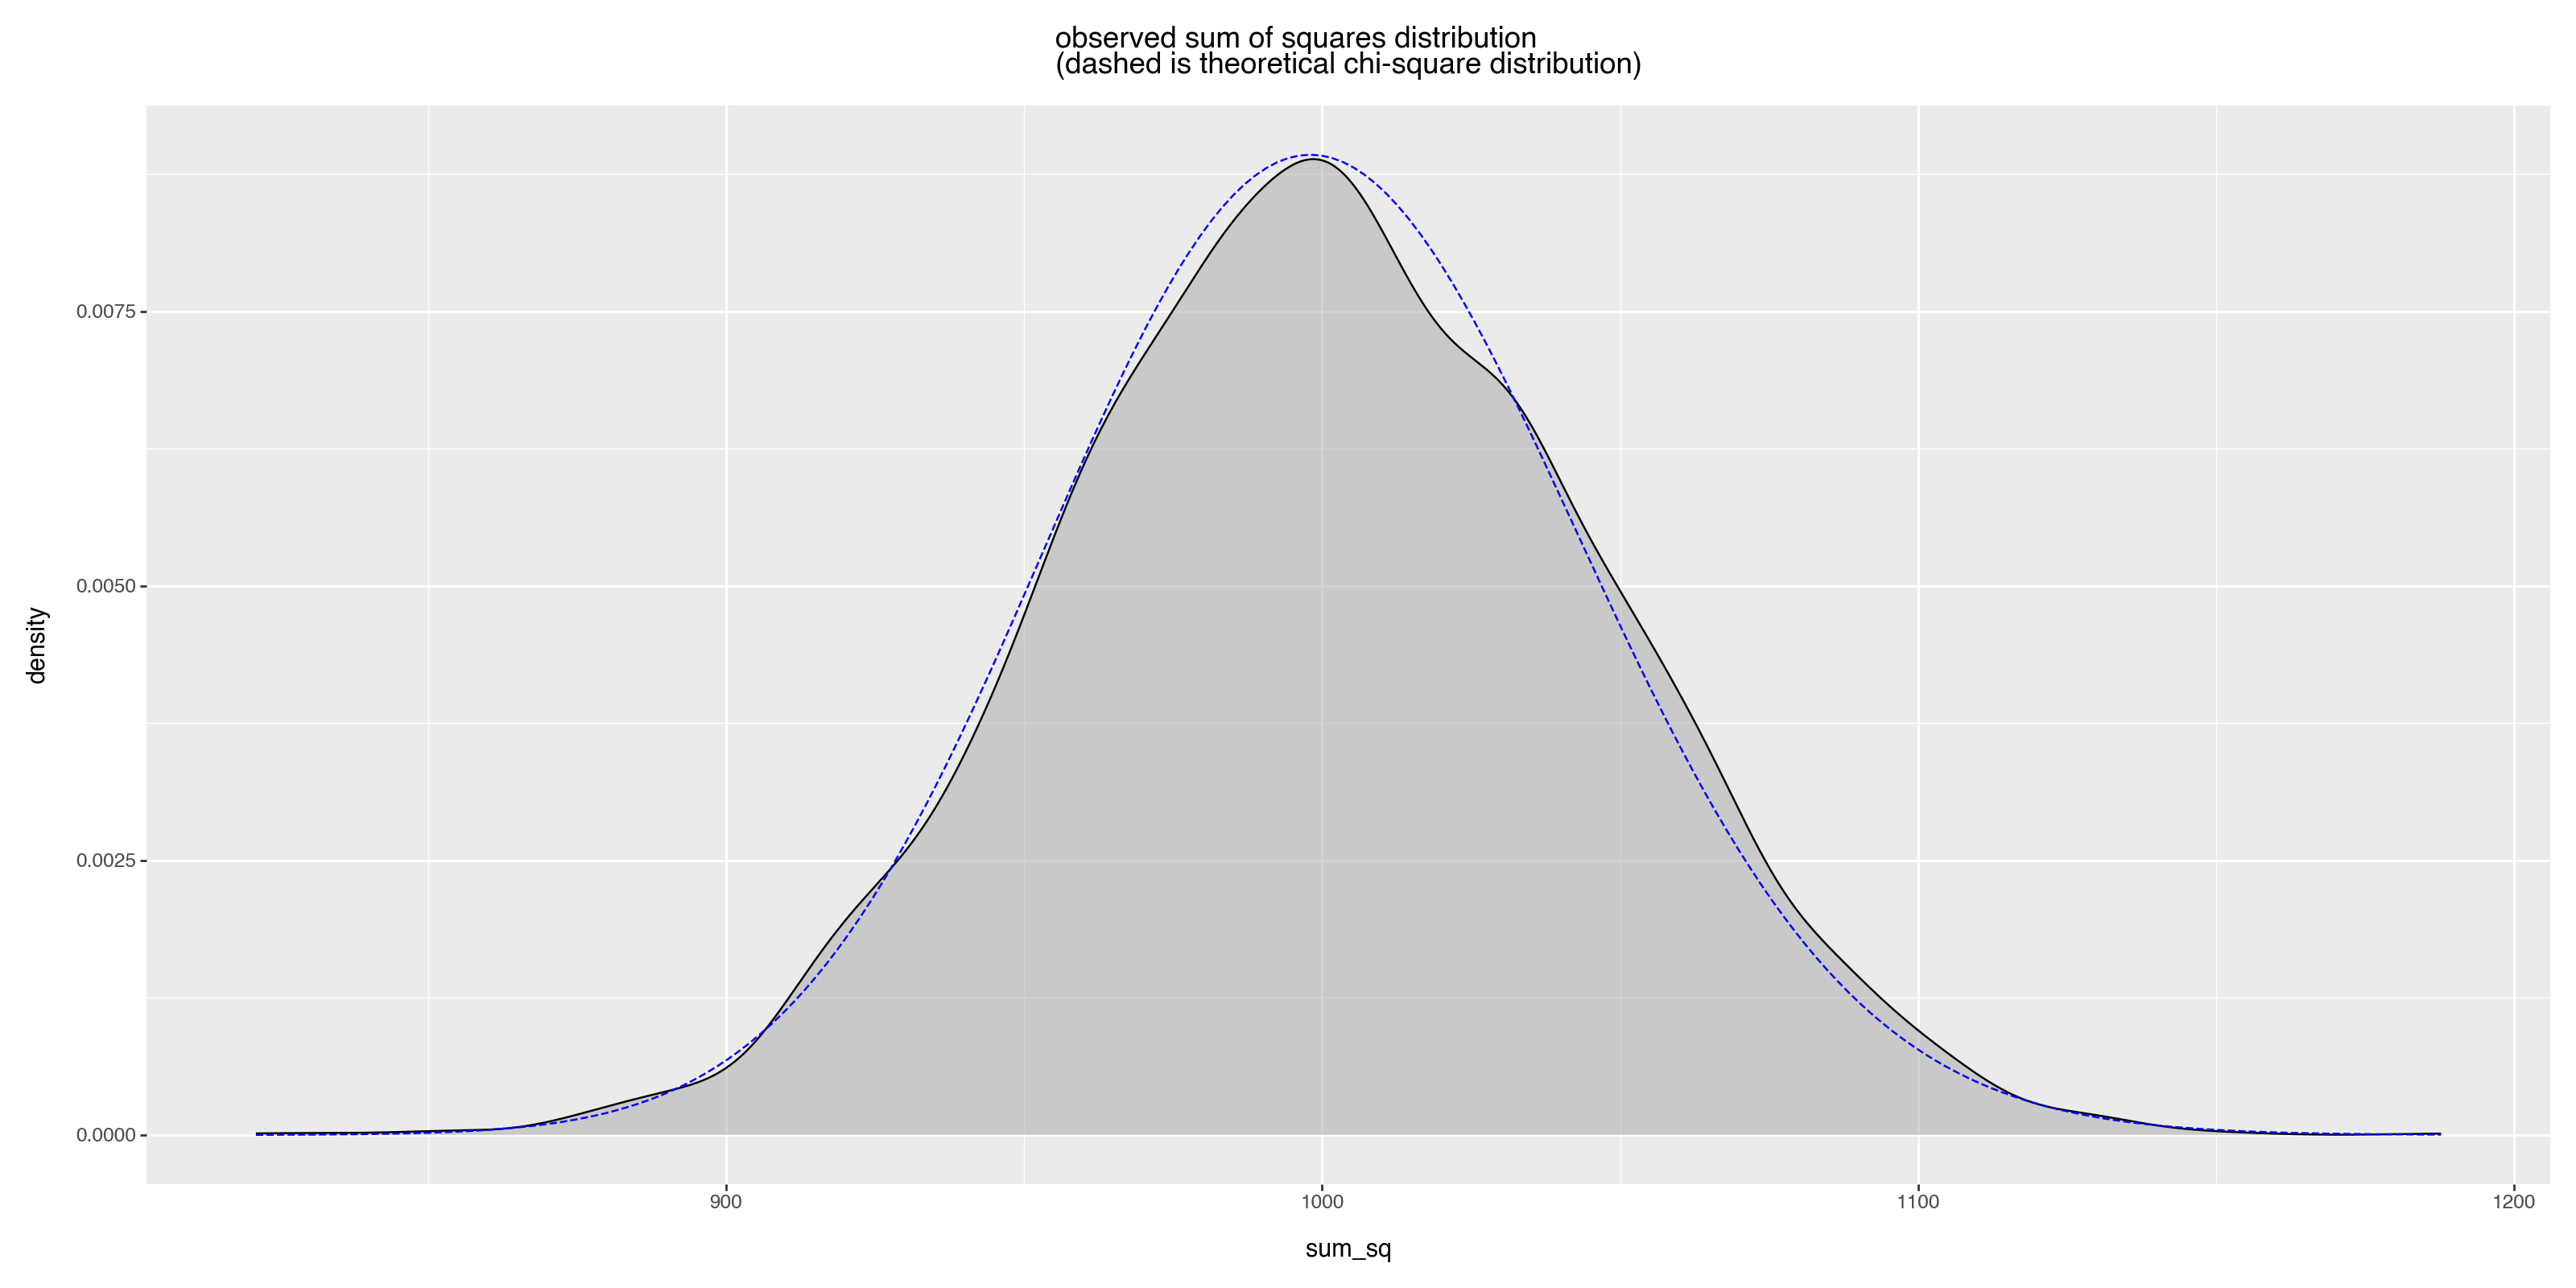

In [14]:
density = pd.DataFrame({
    'sum_sq': np.linspace(
        start=min(N - 4 * np.sqrt(2 * N), np.min(res['sum_sq'])), 
        stop=max(N + 4 * np.sqrt(2 * N), np.max(res['sum_sq'])), 
        num=200),
})
density['pdf'] = chi2.pdf(density['sum_sq'], df=N)
(
    ggplot()
    + geom_density(
        data=res,
        mapping=aes(x='sum_sq'),
        fill='darkgrey', 
        alpha=0.5)
    + geom_line(
        data=density,
        mapping=aes(x='sum_sq', y='pdf'), 
        color='blue', 
        linetype='dashed',
    )
    + ggtitle(
        "observed sum of squares distribution"
        + "\n(dashed is theoretical chi-square distribution)")
)